# Question 0

In [10]:
import csv
import matplotlib.pyplot as plt
import numpy as np

In [11]:
N = 500
T = 100

data_file = 'meteo0.csv'
data = np.ones((N, T))
with open(data_file) as csvDataFile:
    csvReader = csv.reader(csvDataFile, delimiter =' ')
    count=0
    for row in csvReader:
        for n in range(len(row)):
            data[count, n] = row[n]
        count +=1  

In [12]:
p_v1_0 = np.sum([data[:,0] == 0])
p_v1_1 = np.sum([data[:,0] == 1])
p_v1_2 = np.sum([data[:,0] == 2])
b
p_v1 = [p_v1_0/N, p_v1_1/N, p_v1_2/N]
print(p_v1)

[0.308, 0.512, 0.18]


In [13]:
A = np.zeros((3,3, N))

for i in range(N):
    for j in range(T-1):
        A[int(data[i,j]), int(data[i,j+1]), i] += 1
    A[:,:,i] = A[:,:,i]/np.sum(A[:,:,i], axis=0)

E = np.sum(A, axis=2)/N
print(E)

[[0.67702285 0.17445944 0.        ]
 [0.1926048  0.69202978 0.31957168]
 [0.13037236 0.13351079 0.68042832]]


# Question 2

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
V = np.array([0, 1, 0, 2, 0, 2, 1, 0, 2, 0])
#Emmission
A = np.array([[0.3, 0.5], [0.6,0],[0.1,0.5]])
#Transition
T = np.array([[0.5,0.8], [0.5, 0.2]])

initial_dist = np.array([[1,0]])


def forward(V, A, T, initial_dist):
    alpha = np.zeros((V.shape[0], T.shape[0]))
    alpha[0,:] = initial_dist*A[V[0],:]
    alpha[0,:] = alpha[0,:]/np.sum(alpha[0,:])
    
    for t in range(1, V.shape[0]):
        for j in range(T.shape[0]):
            alpha[t,j] = alpha[t-1]@T[j,:]*A[V[t], j]
        
        alpha[t,:] = alpha[t,:]/np.sum(alpha[t,:])
    
    return alpha

alpha = forward(V,A,T, initial_dist)

def backward(V, A, T):
    beta = np.zeros((V.shape[0], T.shape[0]))
    beta[V.shape[0] - 1,:] = np.ones((T.shape[0]))
    beta[V.shape[0] - 1,:] = beta[V.shape[0] - 1,:]/np.sum(beta[V.shape[0] - 1,:])
    
    for t in range(V.shape[0] -2, -1, -1):
        for j in range(T.shape[0]):
            beta[t,j]=(beta[t+1]* A[V[t+1],:])@T[:,j]
    
        beta[t,:] = beta[t,:]/np.sum(beta[t,:])
    return beta

beta = backward(V,A,T)

p_ht = np.zeros((T.shape[0],V.shape[0]))

for t in range(0,V.shape[0]):
    p_ht[0,t] = alpha[t,0]*beta[t,0] #*A[V[t],0]
    p_ht[1,t] = alpha[t,1]*beta[t,1] #*A[V[t],1]



p_ht = (p_ht/np.sum(p_ht, axis = 0)).T
print(p_ht)
    

[[1.         0.        ]
 [1.         0.        ]
 [0.50239234 0.49760766]
 [0.29824561 0.70175439]
 [0.73205742 0.26794258]
 [0.17065391 0.82934609]
 [1.         0.        ]
 [0.48837209 0.51162791]
 [0.34108527 0.65891473]
 [0.59302326 0.40697674]]


In [3]:
p_h1_h2 = np.zeros(T.shape)
p_h4_h5 = np.zeros(T.shape)

for i in range(p_h1_h2.shape[0]):
    for j in range(p_h1_h2.shape[1]):
        p_h1_h2[i,j] = alpha[0,i]* beta[1, j]*T[i,j]*A[V[1],j] #*A[V[0],i]
        p_h4_h5[i,j] = alpha[3,i]* beta[4, j]*T[i,j]*A[V[4],j] #*A[V[3],i]

p_h1_h2=p_h1_h2/np.sum(p_h1_h2)
print(p_h1_h2)

p_h4_h5 = p_h4_h5/np.sum(p_h4_h5)
print(p_h4_h5)


[[1. 0.]
 [0. 0.]]
[[0.18171806 0.25844347]
 [0.41299559 0.14684288]]


In [4]:
def calcLowerBound(V, TEst, response):
    free_energy = 0 
    for t in range(V.shape[0]-1):
        for i in range(2):
            for j in range(2):
                free_energy += response[i,j,t]*np.log(TEst[i,j])
    
    return(free_energy)

In [5]:
def baumWelch(V, A, initial_dist):
    #Initialise Transition matrix
    T = np.array([[0.5,0.8], [0.5, 0.2]])
    #Number of data points
    ndata = V.shape[0]
    
    #Initalise response matrix for 2x2 transition p(ht,ht+1|v1:T)
    response = np.zeros((2,2,ndata-1))
    
    #Initialise free energy
    free_energy=[]
    
    epsilon = 0.0001
    nIter = 0
    running = True
    while running:
        #E step - update the probability distribtuion p(ht, ht+1|v, \theta)
        #Given the current T we want to update the posterior dist on hts
        
        alpha = forward(V, A, T, initial_dist)
        beta = backward(V, A, T)
        
        #Expectation step
        for t in range(ndata-1):
            for i in range(2):
                for j in range(2):
                    #calc response p(ht =i, ht+1 = j|v1:T and param)
                    response[i,j,t] = alpha[t, i]*T[i,j]*A[V[t+1],j]*beta[t+1,j]
            #Normalise with respect to each i and j
            summond = np.sum(np.sum(response[:,:,t]))
            if summond ==0:
                summond=1
                
            response[:,:,t] = response[:,:,t]/summond
            
        
        #M step
        #Sum up all responses and normalise wrt to the sum over rows.
        T_dum = np.sum(response,axis=2)/np.sum(np.sum(response, axis=1), axis=1).reshape((-1,1))
        
        
        free_eng = calcLowerBound(V, T, response)
        free_energy.append(free_eng)
        
        if  nIter == 200 or (np.linalg.norm(T - T_dum) < epsilon):
            running =False
        nIter += 1  
        
        T = T_dum.T
    
    x = np.arange(nIter)
    plt.plot(x,free_energy)
    
    print(nIter)
    
    return T

201
[[0.86814329 0.09006879]
 [0.13185671 0.90993121]]


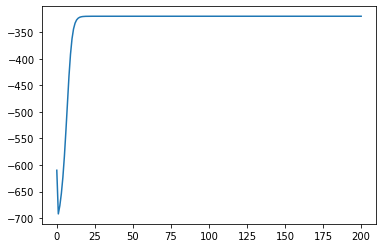

In [7]:
chess_results = []

f = open('chess.txt', 'r')
for item in f.read():
    if item != '\n':
        chess_results.append(int(item))

chess_results = np.array(chess_results) 

A = np.array([[0.3, 0.5], [0.6,0],[0.1,0.5]])

initial_dist = np.array([[1,0]])

T = baumWelch(chess_results, A, initial_dist)
print(T)

# Part (f)

Here we do a forward and backward pass through the algorithm and then calculate the most likely state for h1000 and use learned transition to calculate most likely state for h1001 and use our emission matrix to calculate the final probability.

In [9]:
a = forward(chess_results, A, T, initial_dist)
b = backward(chess_results, A, T)
V = chess_results

p_h1000 =[]
p_h1000.append(a[1000-1,0]*b[1000-1,0]*A[V[1000-1],0])
p_h1000.append(a[1000-1,1]*b[1000-1,1]*A[V[1000-1],1])

print(V[999])
h1000 = np.argmax(p_h1000)
print(h1000)
h1001 = np.argmax(T[h1000,:])
print(h1001)

print(A[:, h1001])
v1001 = np.argmax(A[:,h1001])
print(v1001) #50 50 whether visible  is 0 or 2

0
1
1
[0.5 0.  0.5]
0
